# Experiment with the response of WAsP's Roughness Change model

In this notebook, we will use `pywasp` to explore the sensitivity of WAsP roughness change induced speedups to various parameters of a single roughness change line.

For simplicity, the single roughness change line will be represented as a circular roughness change. In this way we can focus on any individual sector and get the same results, rather than having to worry whether we picked the right sector which contains a single roughness change line.

The circular roughness change is depict in the image below, where a mast is located at the `X`, and a roughness change is created with a radius `r`, where the roughness changes from an `inner-roughness` (light green circle) to an `outer-roughness` (dark green area sourrounding the circle).

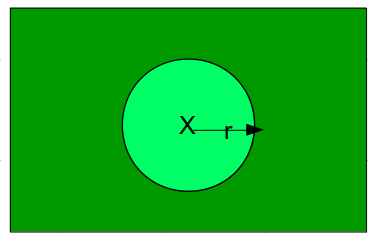

In this example, we will:

1. Identify the necessary inputs to a provided function that creates a circular roughness map.
2. Create a `pandas.DataFrame` of test cases from a list of variables.
3. Call a function that calculates speedups for the Northerly sector based on a `pandas.Series` of inputs.
4. Examine the speedup results to understand some of the behavior of the WAsP roughness change model.

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import pywasp as pw

## Circular roughness map

To creater a circular roughness map a function is provided in the module `circular_roughness_map`. The function requires the following inputs:

 - `radius` of the circle
 - `z01` the `inner-roughness` length
 - `z02` the `outer-roughness` length

to be passed:

```
circular_roughness_map(radius, z01, z02)
```


Let's import this function and generated an example of roughness map.

> **__notebook note__**: You can pull up help in jupyter notebooks by placing a `?` in front of the function, and you can get the entire function by using `??`.

In [3]:
from circular_roughness_map import circular_roughness_map

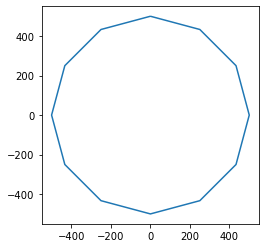

In [4]:
rgh_map = circular_roughness_map(500, .0002, 0.01)
rgh_map.plot();

The plot shows only a 'circle' represented by 12 points corresponding to the default number of roughness rose sectors. 
To validate that the roughness lenghts are correctly set we can plot `rough_map` as a raster map: 

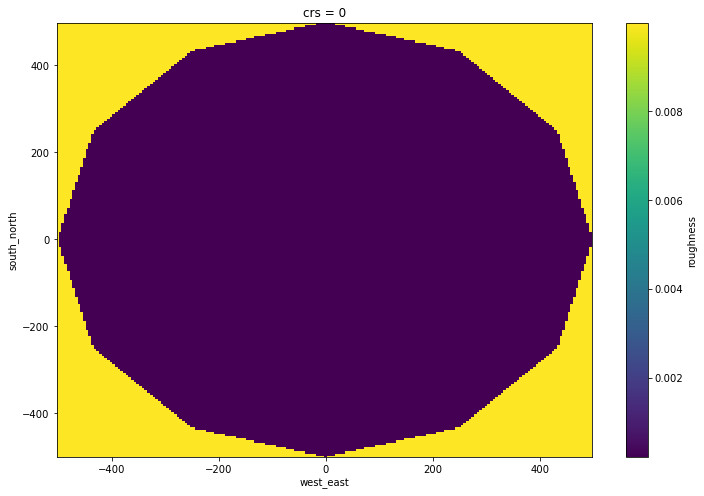

In [5]:
pw.vectormap_to_rastermap(rgh_map, res = 5).plot(figsize=(12, 8));

We can also see the value of the dataset by printing it:

In [6]:
print(rgh_map)

   z0_left  z0_right                                           geometry  n_pts
0     0.01    0.0002  LINESTRING (0.000 500.000, 250.000 433.013, 43...     13


## Setup the test cases

We will setup a number of roughness test cases that we will use later on to assess the response of WAsP's Roughness Change model. The test cases will be described by:

 - `radius` of the circle
 - `z01` the `inner-roughness` length
 - `z02` the `outer-roughness` length
 - `height` above the ground level where the roughness change induced speedups will be assessed
 - `p40` the factor for upper kink in roughness change profile
 - `p41` the factor for lower kink in roughness change profile
 
We will vary `radius`, `z01`, `z02` and `height` in our test cases, but we will fix values of `p40` and `p41`.

> **__pywasp note:__** `p40` and `p41` are used to calculate the range of heights of the internal boundary layer which corresponds to the transition layer (see the figure below). Typically we say that the transition layer occupies the range of heights starting at 9% all the way to 30% of the internal boundary layer height. Considering the notation in the image below this means that `h1 = 0.3 h` while `h2 = 0.09 h` ,

![IBL structure](images/IBL_layers.png)
*Source: Tsz Yan Kwok*

Here we create a Pandas DataFrame, which can be thought of as similar to an Excel Spreadsheet. We will use numpy's meshgrid function to create an orthogonal dataset out of all of the lists we provide as input. Giving us a total of 567 unique cases for our test.

In [7]:
rad = np.linspace(500., 50000., 21) # Radius of the circle
height = [10., 50., 100.] # Height above ground
z01 = [.0002, 0.03, 0.3]  # Inner roughness length
z02 = [0.01, 0.1, 0.5]    # Outer roughness length
p40 = [.30]               # Factor for upper kink in roughness change profile
p41 = [.09]               # Factor for lower kink in roughness change profile


tests = pd.DataFrame(np.array(np.meshgrid(rad, z01, z02, height, p40, p41, )).T.reshape(-1, 6), 
                         columns = ["radius", "z01", "z02", "height", "p40", "p41"])

tests[:10]# showing only first 10 rows out of 567

,radius,z01,z02,height,p40,p41
0,500.0,0.0002,0.01,10.0,0.3,0.09
1,500.0,0.0300,0.01,10.0,0.3,0.09
2,500.0,0.3000,0.01,10.0,0.3,0.09
3,2975.0,0.0002,0.01,10.0,0.3,0.09
4,2975.0,0.0300,0.01,10.0,0.3,0.09
5,2975.0,0.3000,0.01,10.0,0.3,0.09
6,5450.0,0.0002,0.01,10.0,0.3,0.09
7,5450.0,0.0300,0.01,10.0,0.3,0.09
8,5450.0,0.3000,0.01,10.0,0.3,0.09
9,7925.0,0.0002,0.01,10.0,0.3,0.09


## Create a column speedups

We will create a new column `'speedup'` containing roughnes induced speedups and add it to `tests` `DataFrame`.
To do this we will use a function provided in the module `calc_rgh_speedup`. The input to this function is a single row of our `tests` `DataFrame`. We will now loop over all of the rows of `tests` `DataFrame` using the `iterrows` function of the dataframe, calculate speedups and add results as the new column to `tests` `DataFrame`.

> **__notebook note:__** Here we are using Ipython's inbuilt timing function to show how long it takes to run our tests. By using double percent signs `%%` we signify that we want to capture the time for the whole cell, a single percent sign `%` will only apply to the line that it is on.

In [8]:
%%time
from calc_rgh_speedup import calc_rgh_speedup

speedup = [calc_rgh_speedup(row) for index, row in tests.iterrows()]
tests.insert(6, "speedup", speedup, True)

tests[:10] # showing only first 10 rows out of 567

CPU times: user 9.83 s, sys: 355 ms, total: 10.2 s
Wall time: 10.2 s


,radius,z01,z02,height,p40,p41,speedup
0,500.0,0.0002,0.01,10.0,0.3,0.09,1.049949
1,500.0,0.0300,0.01,10.0,0.3,0.09,1.000000
2,500.0,0.3000,0.01,10.0,0.3,0.09,0.821664
3,2975.0,0.0002,0.01,10.0,0.3,0.09,1.085181
4,2975.0,0.0300,0.01,10.0,0.3,0.09,0.953899
5,2975.0,0.3000,0.01,10.0,0.3,0.09,0.783460
6,5450.0,0.0002,0.01,10.0,0.3,0.09,1.068527
7,5450.0,0.0300,0.01,10.0,0.3,0.09,0.959597
8,5450.0,0.3000,0.01,10.0,0.3,0.09,0.802131
9,7925.0,0.0002,0.01,10.0,0.3,0.09,1.053543


## Examine the speedup results 

We will plot the test results as line charts of the speedups based on height, roughness length, and distance of the roughness change. We will use `plotnine` for this work. 

> **__notebook note__:** if your conda enviroment does not contain `plotnine` install it by running the following command in your terminal:<br>`conda install -c conda-forge plotnine`<br> We will use `plotnine` to make final plots of this tutorial. 

> **__notebook note__:** `ggplot` will raise  `MatplotlibDeprecationWarning`, which is a known warning.

In [9]:
from plotnine import ggplot, aes, geom_line, facet_grid


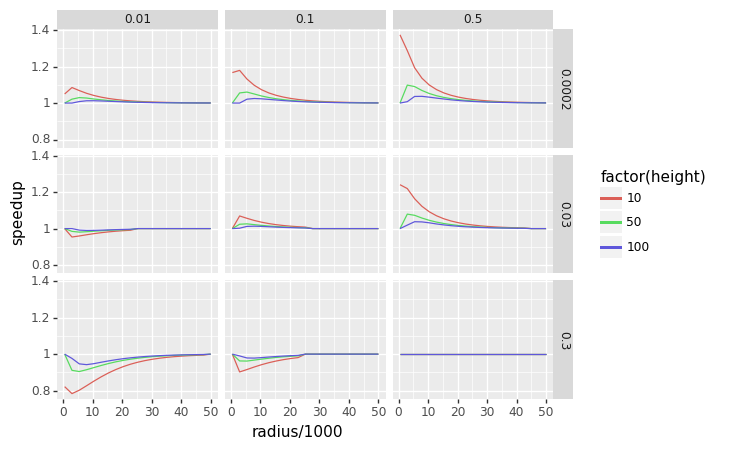

<ggplot: (319529371)>

In [10]:
(ggplot(tests, aes('radius/1000', 'speedup', color='factor(height)'))
 + geom_line()
 + facet_grid('z01~z02')
)